## 基本面数据来自于中基石化，气候价格数据来自ricequant，接口部分（rq.init）作模糊处理

In [1]:
#导入函数库
#数据库导入
#import Ipynb_importer   #导入Ipynb文件，每次更新需要restart

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn import preprocessing
from datetime import datetime 
from datetime import date 
import time
#import data_dimension_reduction as rd
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY,YEARLY
from matplotlib.ticker import PercentFormatter
from sklearn import linear_model
from sklearn.linear_model import Lasso
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score


#import tool as tl


import rqdatac as rq
from rqdatac import *
rq.init('+992************(账号)', 'JuWl********(密码)')

import warnings
warnings.filterwarnings('ignore')


#从繁微里提取数据
def read_finoview(FW_ID,startdate,enddate):
    result_data=pd.DataFrame()
    url = 'https://finoview.com.cn/autoApi/All_IndexData'
    requests.packages.urllib3.disable_warnings()
    for i in FW_ID:
        try:
            querystring={"superIndexLabel": i,"StartDate": startdate, "EndDate": enddate,'appkey':"E35C416E470D94A4D941AA21C31FCF0F","appsecret":"9487735a2189438ba35d7cf73053e191"}
            response = requests.request("POST", url, params=querystring, verify=False)
            dict1=eval(response.text)
            data=pd.DataFrame(dict1['data'])
            result_data=pd.concat([result_data,data],axis=0)
            print(i)
        except:
            print(i+"失败！")
    return result_data

def tradedays(start,end):
    '''
    计算两个日期间的工作日
    start:开始时间
    end:结束时间
    '''
    from datetime import datetime,timedelta
    from chinese_calendar import is_holiday
    # 字符串格式日期的处理
    if type(start) == str:
        start = datetime.strptime(start,'%Y-%m-%d').date()
    if type(end) == str:
        end = datetime.strptime(end,'%Y-%m-%d').date()
    # 开始日期大，颠倒开始日期和结束日期
    if start > end:
        start,end = end,start
        
    counts = 0
    while True:
        if start > end:
            break
        if is_holiday(start) or start.weekday()==5 or start.weekday()==6:
            start += timedelta(days=1)
            continue
        counts += 1
        start += timedelta(days=1)
    return counts

def judge_trading_day(index,list_days):   #判断是否属于交易日
    result = list()
    for i in index:
        if i in list_days:
            result.append(True)
        else:
            result.append(False)
    return result

def PCA_RD(df,n_component):     #标准化之后进行降维
    
    #pca降维，（计算可解释方差）
    X_pca = df.iloc[:,1:].fillna(method='bfill')
    y_pca = df.iloc[:,0]
    cov_mat = np.cov(X_pca.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)

    # 特征值和对应的特征向量组成的元组列表
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

    # 按特征值大小从高到低排序
    eig_pairs.sort(key=lambda x: x[0], reverse=True)

    #保留95%信息,pca降维
    pca_rb = PCA(n_components=n_component)

    Y_2 = pca_rb.fit_transform(X_pca)
    print('n_dim:',pca_rb.n_components_)
    n_dim = pca_rb.n_components_
    data_pca = pd.DataFrame(Y_2)
    data_pca.columns = ['rd'+str(j+1) for j in range(0,len(data_pca.columns))]  #设置列名
    data_pca.index = df.index
    return data_pca

def CalAverageHoldingTime(position):    #.构建回测分析函数Analysis
    period = 5   #预测周期
    position=np.array(position)
    position_shift=pd.Series(position)
    position_shift=position_shift.shift(1)
    position_shift=np.array(position_shift)
    AverageHoldingTime=position.shape[0]/(((position==position_shift)==0).sum()-1)
    print('平均持仓时间:',round(AverageHoldingTime,2)*period)
    file_object = open('CalAverageHoldingTime_20211117.csv', 'a')
    file_object.writelines(str(AverageHoldingTime)+',')
    file_object.writelines('\n')
    file_object.close()
    return AverageHoldingTime*period

def CalMaxDrawdown(cumpnl):
    ''' 最大回撤率计算 '''
    netvalue = (cumpnl/10000000.0)
    maxdrawdowns = pd.Series(index = netvalue.index)
    for i in np.arange(len(netvalue.index)):
        highpoint = netvalue.iloc[0:(i+1)].max()
        if highpoint == netvalue.iloc[i]:
            maxdrawdowns.iloc[i] = 0
        else:
            maxdrawdowns.iloc[i] = netvalue.iloc[i] / highpoint - 1
    return maxdrawdowns

def Analysis(netvalue,freq):
    
    if freq == 'w':
        freq_n = 50
    elif freq == 'd':
        freq_n = 252
        
        
    period = 5 #预测周期
    tradedateslen = len(netvalue)*period
    returns = netvalue.pct_change()
    returns = returns.replace([np.inf, -np.inf], np.nan)
    returns = returns.fillna(0)
    returns[0] = netvalue.iloc[0] - 1.0
    totalreturn = netvalue.iloc[-1] - 1.0
    return_yr = (1 + totalreturn) ** (252 / tradedateslen) - 1
    volatility_yr = np.std(returns)*np.sqrt(freq_n)
    #夏普比率
    sharpe = (return_yr - 0.024)/volatility_yr
    # 回撤
    drawdowns = CalMaxDrawdown(netvalue)
    # 最大回撤
    maxdrawdown = min(drawdowns.fillna(0))
    # 收益风险比
    profit_risk_ratio = return_yr / abs(maxdrawdown)
    #盈利次数
    win_count = (returns >= 0).sum()
    #亏损次数
    loss_count = (returns < 0).sum()
    #平均每单盈利
    win_avg=returns[returns>0].sum()/win_count
    #平均每单亏损
    loss_avg=returns[returns<0].sum()/loss_count
    # 胜率
    win_rate = win_count/(win_count + loss_count)
    #盈亏比
    profit_loss_ratio = abs(win_avg/loss_avg)
    # 索提诺比率
    returns_d = returns - 0.024/365
    returns_d[returns_d > 0] = 0              # 下行收益率序列
    volatility_yr_d = np.std(returns_d, ddof=0)*np.sqrt(freq_n)    # 下行年化波动率
    sortino = (return_yr - 0.024) / volatility_yr_d
    
    
    print('总收益:{:.2%}'.format(totalreturn))
    print('年化收益:{:.2%}'.format(return_yr))
    print('年化波动:{:.2%}'.format(volatility_yr))
    print('夏普值:',round(sharpe,2))
    print('最大回撤:{:.2%}'.format(maxdrawdown))
    print('收益风险比:',round(profit_risk_ratio,2))
    print('胜率:',round(win_rate,2))
    print('盈亏比:',round(profit_loss_ratio,2))
    print('sortino比率:',round(sortino,2))
    
    
    #print('win_count',win_count)
    #print('loss_count',loss_count)
    #print('win_avg',win_avg)
    #print('loss_avg',loss_avg)
#     file_object = open('Analysis_20211117.csv', 'a')
#     #file_object.write(str(totalreturn))
#     file_object.writelines(str(totalreturn)+',')  #写入多行
#     file_object.writelines(str(return_yr)+',')
#     file_object.writelines(str(volatility_yr)+',')
#     file_object.writelines(str(sharpe)+',')
#     file_object.writelines(str(maxdrawdown)+',')
#     file_object.writelines(str(profit_risk_ratio)+',')
#     file_object.writelines(str(win_rate)+',')
#     file_object.writelines(str(profit_loss_ratio)+',')
#     file_object.writelines(str(sortino)+',')
#     file_object.writelines('\n')
#     file_object.close()
    return round(sharpe,2)

def show_pic_all(ntv):
    plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
    ntv.index = pd.to_datetime(ntv.index)
    
    plt.figure(figsize=(22,10))
    ax1 = plt.subplot(111)
    ax2 = ax1.twinx()
    ax1.plot(ntv,color='#CC0000',linewidth=3,label='净值曲线')
    ax2.fill_between(ntv.index,CalMaxDrawdown(ntv),color='darkgray',linewidth=0,alpha=0.5,label='回撤')
    ax1.legend(loc=2,fontsize=20)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    ax2.legend(loc=1,fontsize=20)
    plt.title('回测结果',size=25,family='KaiTi')
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.tick_params(labelsize=20)
    ax2.tick_params(labelsize=20)
    for label in ax1.get_xticklabels():
        label.set_rotation(90)
    mondayFormatter = DateFormatter('%Y') 
    ax1.xaxis.set_major_formatter(mondayFormatter)
    ax1.tick_params(axis="x", direction="in", which="both", length=0)
    ax1.tick_params(axis="y", direction="in", which="both", length=0)
    ax2.tick_params(axis="x", direction="in", which="both", length=0)
    ax2.tick_params(axis="y", direction="in", which="both", length=0)
    
    plt.show()
    
def show_pic(ntv,signal,price):
    plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
    ntv.index = pd.to_datetime(ntv.index)
    signal.index = pd.to_datetime(signal.index)
    price.index = pd.to_datetime(price.index)


    plt.figure(figsize=(32,10))
    ax1 = plt.subplot(121)
    ax2 = ax1.twinx()
    ax1.plot(ntv,color='#CC0000',linewidth=3,label='净值曲线')
    ax2.fill_between(ntv.index,CalMaxDrawdown(ntv),color='darkgray',linewidth=0,alpha=0.5,label='回撤')
    ax1.legend(loc=2,fontsize=20)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    ax2.legend(loc=1,fontsize=20)
    plt.title('回测结果',size=25,family='KaiTi')
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.tick_params(labelsize=20)
    ax2.tick_params(labelsize=20)
    for label in ax1.get_xticklabels():
        label.set_rotation(90)
    mondayFormatter = DateFormatter('%Y') 
    ax1.xaxis.set_major_formatter(mondayFormatter)
    ax1.tick_params(axis="x", direction="in", which="both", length=0)
    ax1.tick_params(axis="y", direction="in", which="both", length=0)
    ax2.tick_params(axis="x", direction="in", which="both", length=0)
    ax2.tick_params(axis="y", direction="in", which="both", length=0)
    
    
    ax3 = plt.subplot(122)
    ax4 = ax3.twinx()
    ax3.bar(signal.index,signal,width=10,color='#CC0000',label='因子多空信号')
    ax4.plot(price,'darkgrey',linewidth=3,label='期货主力合约复权价格')
    ax3.legend(loc=2,fontsize=20)
    ax4.legend(loc=1,fontsize=20)
    plt.title('多空信号',size=25,family='KaiTi')
    ax3.spines['top'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax4.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    ax3.tick_params(labelsize=20)
    ax4.tick_params(labelsize=20)
    for label in ax3.get_xticklabels():
        label.set_rotation(90)
    mondayFormatter = DateFormatter('%Y') 
    ax3.xaxis.set_major_formatter(mondayFormatter)
    ax3.tick_params(axis="x", direction="in", which="both", length=0)
    ax3.tick_params(axis="y", direction="in", which="both", length=0)
    ax4.tick_params(axis="x", direction="in", which="both", length=0)
    ax4.tick_params(axis="y", direction="in", which="both", length=0)

    plt.show()


## 数据处理：导入数据，规范化列名，删除高相关，前值填充，数据扩充，导入价格数据

In [2]:
#导入数据
df_eb = pd.read_csv('df_eb.csv',index_col=0) #导入数据
df_eb = df_eb.iloc[67:-37]  #去2015年之后的数据,20228月之前的数据

In [3]:
#筛选数据：设置条件
cond1 = df_eb[df_eb.index<'20150101'].count()>0   #20160101之前有数据
select1 = df_eb.columns[cond1]
df_eb = df_eb[select1]

cond2 = df_eb[df_eb.index>'20210101'].count()>0    #20220101之后有数据
select2 = df_eb.columns[cond2]
df_eb = df_eb[select2]

cond3 = df_eb.nunique()>50   #总数据点超过50个（等于删除半年度、年度数据）
select3 = df_eb.columns[cond3]
df_eb = df_eb[select3]

In [4]:
#删除所有累计值，同比值
for i in df_eb.columns:
    if '累计' in i:
        df_eb = df_eb.drop(columns=i)
for i in df_eb.columns:
    if '同比' in i:
        df_eb = df_eb.drop(columns=i)
for i in df_eb.columns:
    if '环比' in i:
        df_eb = df_eb.drop(columns=i)

In [5]:
#更新列名
df_name = pd.DataFrame(index = df_eb.columns.values,columns=['new_columns'])  
for i in range(0,len(df_name)):
    df_name.iloc[i] = 'fac'+str(i)    
df_eb.columns = df_name['new_columns']

In [6]:
#删除高相关性数据
df_corr = df_eb.corr()
df_corr = (df_corr.applymap(lambda x: np.abs(x)>0.8).sum())
df_eb = df_eb[list(df_corr[df_corr==1].index)]

In [7]:
#前值填充+取交易日数据+扩充数据
#前值填充
df_eb = df_eb.fillna(method='ffill')

#取交易日数据
trading_days = get_trading_dates(start_date='20150101', end_date='20220731')
df_eb.index = pd.to_datetime(df_eb.index)
df_eb = df_eb.T[(trading_days)].T

#扩充基本面数据数据
for i in df_eb.columns:
    df_eb[i+'_yr_ratio'] = df_eb[i]/df_eb[i].shift(244)
    df_eb[i+'_qt_ratio'] = df_eb[i]/df_eb[i].shift(61)
    df_eb[i+'_mo_ratio'] = df_eb[i]/df_eb[i].shift(20)
    df_eb[i+'_yr_delta'] = df_eb[i]/df_eb[i].shift(244)
    df_eb[i+'_qt_delta'] = df_eb[i]/df_eb[i].shift(61)
    df_eb[i+'_mo_delta'] = df_eb[i]/df_eb[i].shift(20)

## 导入期货复权价格，并计算收益率

In [8]:
#导入价格数据
price_eb = rq.futures.get_dominant_price(underlying_symbols='EB',start_date=20150101,end_date=20220726,frequency='1d',fields=None,adjust_type='pre')
price_eb = price_eb.reset_index(level=0)['settlement']

#计算周度收益率，需要考虑到节假日因素；若前一周有节假日，则以前一周最后一天作为基准计算
price_eb = pd.DataFrame(price_eb)
price_eb['trade_day'] = pd.Series(price_eb.index.strftime('%y%W')).values   #某年第几个星期（%y%W）;某年第几个星期（%y%m）
price_eb['week_day'] = pd.Series(price_eb.index.strftime('%w')).values

#计算周度，月度收益,收益的计算还是以前五个交易日
price_eb = pd.DataFrame(price_eb)
price_eb['return_w'] = price_eb['settlement']/price_eb['settlement'].shift(5)-1
price_eb['return_m'] = price_eb['settlement']/price_eb['settlement'].shift(20)-1
price_eb['return_d'] = price_eb['settlement']/price_eb['settlement'].shift(1)-1

week_days = price_eb.drop_duplicates(['trade_day'],keep='last').iloc[:-1]    #若前一周有节假日，则以前一周最后一天作为基准计算（用于开仓）

#预测未来价格
df_eb['return_w'] = price_eb['return_w'].shift(-5)
df_eb['return_d'] = price_eb['return_d'].shift(-1)
df_eb['return_m'] = price_eb['return_m'].shift(-20)
df_eb['week_day'] = week_days['week_day'].astype(int)

In [9]:
#保持数据长度统一
df_eb = df_eb.iloc[1155:]

## 模型回测：PCA，标准化，OLS

In [10]:
#滚动回归
lookback_days=244
pred_eb = pd.Series()
for i in range(lookback_days,len(df_eb)):  #for 循环周期
    if not np.isnan(df_eb['week_day'].iloc[i]):    #每周最后一天进行换仓，不一定是周五
        print(i)     #每次循环重新降维
        x_pca = PCA_RD(df_eb.iloc[i-lookback_days:i+1,:-4].replace([np.inf,-np.inf,np.nan],0),0.9)   #包括训练集和测试集
        #x_pca = rd.KPCA_RD(df_cu.iloc[i-lookback_days:i+1,:-4].replace([np.inf,-np.inf,np.nan],0),10,30,'poly')
        x_ols = x_pca.iloc[:lookback_days]
        y = df_eb.iloc[i-lookback_days:i,:]['return_w']
        #x_ols = sm.add_constant(x_ols)
        
        #OLS回归
        est = sm.OLS(y.fillna(0).values,x_ols.replace([np.nan,np.inf,-np.inf],0).values)
        
        #Lasso回归
#         model = Lasso(alpha=0.1)
#         model.fit(y.fillna(0).values,x_ols.replace([np.nan,np.inf,-np.inf],0).values)
        
        
        
        model = est.fit()
        x_pred = x_pca.iloc[-1]
        y_pred = model.predict(x_pred.values)
        y_pred = pd.Series(y_pred[0])
        #y_pred.index = [(df_cu.iloc[i,-100:-3].name)]
        y_pred.index = [(x_pred.name)]
        pred_eb = pred_eb.append(y_pred)
        print(y_pred)

246
n_dim: 4
2020-09-30    0.014491
dtype: float64
247
n_dim: 4
2020-10-09    0.020152
dtype: float64
252
n_dim: 4
2020-10-16    0.024428
dtype: float64
257
n_dim: 4
2020-10-23    0.022558
dtype: float64
262
n_dim: 4
2020-10-30    0.037862
dtype: float64
267
n_dim: 4
2020-11-06    0.068054
dtype: float64
272
n_dim: 4
2020-11-13    0.117919
dtype: float64
277
n_dim: 4
2020-11-20    0.085796
dtype: float64
282
n_dim: 4
2020-11-27    0.042525
dtype: float64
287
n_dim: 4
2020-12-04   -0.000443
dtype: float64
292
n_dim: 4
2020-12-11    0.008111
dtype: float64
297
n_dim: 5
2020-12-18   -0.071376
dtype: float64
302
n_dim: 5
2020-12-25   -0.079251
dtype: float64
306
n_dim: 5
2020-12-31   -0.027296
dtype: float64
311
n_dim: 5
2021-01-08    0.005543
dtype: float64
316
n_dim: 5
2021-01-15    0.017587
dtype: float64
321
n_dim: 5
2021-01-22    0.017645
dtype: float64
326
n_dim: 5
2021-01-29    0.008912
dtype: float64
331
n_dim: 5
2021-02-05    0.009479
dtype: float64
334
n_dim: 5
2021-02-10    0.02

## 下列单元格当中阈值参数（threshold）可以调整：阈值越高，空仓越多，胜率越高;
## 阈值推荐范围为[0.00,0.05]

In [11]:
#回测部分，考虑开仓阈值，手续费，仓位控制等
threshold=0.01
period = 5
df_bkt = pd.DataFrame()      #定义回测序列
df_bkt['return_pred'] = pred_eb   #收益率预测值
df_bkt['price'] = price_eb['settlement']
df_bkt['real_return'] = price_eb['return_w'] #真实收益率（未来）
df_bkt['rank'] = range(1,len(df_bkt)+1)
df_bkt['sign'] = (np.sign(np.abs(df_bkt['return_pred'])-threshold)).replace(-1,0)*np.sign(df_bkt['return_pred'])  #根据阈值定义开平仓信号
df_bkt['fee'] = np.abs(df_bkt['sign']-df_bkt['sign'].shift(1))*0.01    #0.007
df_bkt['fee'].iloc[0] = np.abs(df_bkt['sign'].iloc[0])*0.01   #0.007
df_bkt['ntv'] = (df_bkt['sign']*df_bkt['real_return']+1-df_bkt['fee']).cumprod()

df_bkt.head(5)

,return_pred,price,real_return,rank,sign,fee,ntv
2020-09-30,0.014491,3921.0,-0.010598,1,1.0,0.01,0.979402
2020-10-09,0.020152,4005.0,0.015209,2,1.0,0.00,0.994298
2020-10-16,0.024428,4505.0,0.124844,3,1.0,0.00,1.118430
2020-10-23,0.022558,4699.0,0.043063,4,1.0,0.00,1.166593
2020-10-30,0.037862,5141.0,0.094063,5,1.0,0.00,1.276326


## 结果分析

总收益:171.46%
年化收益:70.82%
年化波动:30.13%
夏普值: 2.27
最大回撤:-24.04%
收益风险比: 2.95
胜率: 0.63
盈亏比: 1.44
sortino比率: 6.68
平均持仓时间: 16.8


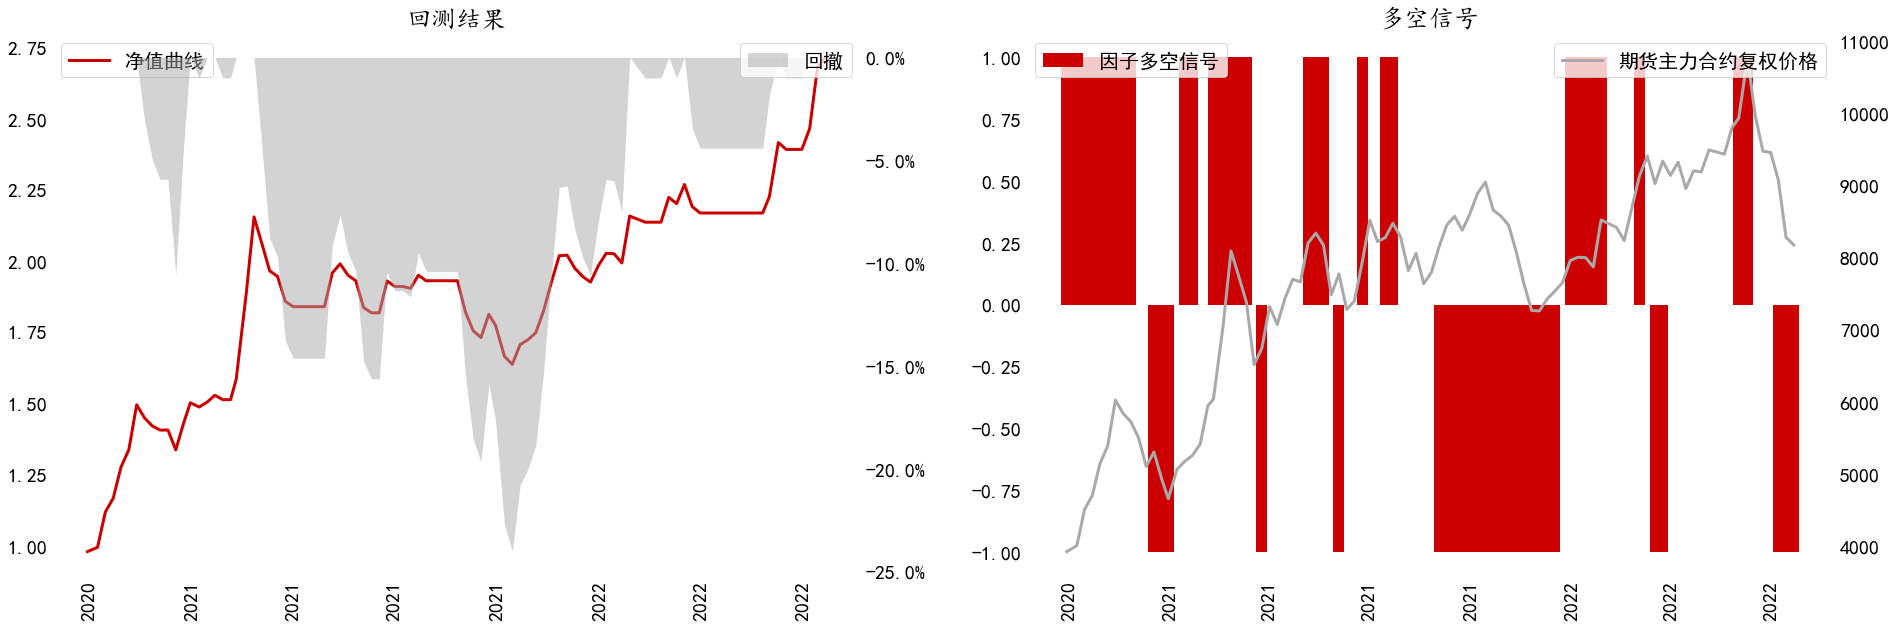

In [12]:
Analysis(df_bkt['ntv'],freq='w')
CalAverageHoldingTime(df_bkt['sign'])
show_pic(df_bkt['ntv'],df_bkt['sign'],df_bkt['price'])